In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten,  Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, Concatenate, Lambda, BatchNormalization, concatenate
from tensorflow.keras.models import Model, Sequential
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline

import tensorflow as tf

Using TensorFlow backend.


In [ ]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import vae_functions, model

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_deblender, load_alpha, denorm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent

In [3]:
from generator_deblender import BatchGenerator_lsst_process, BatchGenerator

# Function to import dense VAE

In [4]:
# Parameters
batch_size = 100
original_dim = 64*64*6

In [19]:
alpha = K.variable(1e-4)
deblender, encoder, Dkl = load_deblender('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v4/', '/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v8/mse/', 6, folder = True)
K.set_value(alpha, load_alpha('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v4/'))
# v7 / v3     # v5/ v2/

def deblender_loss(x, x_decoded_mean):
    xent_loss = K.mean(K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=[1,2,3]))#original_dim*
    kl_loss = K.get_value(alpha) * Dkl
    return xent_loss + K.mean(kl_loss)

deblender.compile('adam', loss=deblender_loss, metrics=['mse'])

## Stamp size for plots

In [6]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# Load test list

In [7]:
test = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_2_v4.npy')

KeyboardInterrupt: 

In [ ]:
test.shape

In [18]:
I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]
beta = 5
for i in range (len(test)):
    for j in range (10):
        test[i,0,j] = np.tanh(np.arcsinh(test[i,0,j]/(I[j]/beta)))
        test[i,1,j] = np.tanh(np.arcsinh(test[i,1,j]/(I[j]/beta)))


NameError: name 'test' is not defined

In [ ]:
r= np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_redshift_v4.npy')

# Function to compute the delta_r for each blended image

In [7]:
def delta_r_min(shift_path):
    shift =np.load(shift_path)
    
    #Reshape the list of shifts so that it is easily usable
    shifts = np.zeros((len(shift),4,2))
    for i in range (len(shift)):
        for j in range (len(shift[i])):
            shifts[i][j] = shift[i][j]
    #print(shifts)    
    # set lists
    deltas_r= np.zeros((len(shift),4))
    delta_r= np.zeros((len(shift)))
    
    # compute the delta r for each couple of galaxies
    for i in range (4):
        deltas_r[:,i] = np.sqrt(np.square(shifts[:,i,0])+np.square(shifts[:,i,1]))

    # Take the min of the non zero delta r
    for j in range (len(shifts)):
        # If all the deta_r are equals to 0 (there is only on galaxy on the image) then write 0
        if (deltas_r[j,:].any() == 0):
            delta_r[j] = 0
        else:
            x = np.where(deltas_r[j] == 0)[0]
            deltas = np.delete(deltas_r[j],x)
            delta_r[j] = np.min(deltas)
    
    return delta_r

In [8]:
delta_r = delta_r_min('/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_shift_v4.npy')

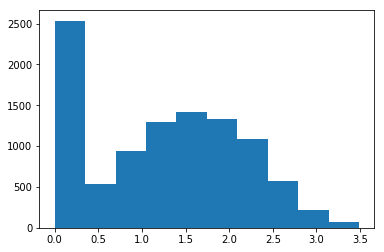

In [38]:
_ = plt.hist(delta_r)

# Batch generation

In [8]:
class BatchGenerator_lsst_for_tests(tf.keras.utils.Sequence):
    """
    Class to create batch generator for the LSST deblender
    """
    def __init__(self, list_of_samples, list_of_shifts, total_sample_size, batch_size,size_of_lists, training_or_validation):
        """
        Initialization function
        total_sample_size: size of the whole training (or validation) sample
        batch_size: size of the batches to provide
        list_of_samples: list of the numpy arrays which correspond to the whole training (or validation) sample
#        path: path to the first numpy array taken in which the batch will be taken
        training_or_validation: choice between training of validation generator
        x: input of the neural network
        y: target of the neural network
        r: random value to sample into the validation sample
        """
        self.total_sample_size = total_sample_size
        self.batch_size = batch_size
        self.list_of_samples = list_of_samples
        self.list_of_shifts = list_of_shifts
#        self.path = random.choice(self.list_of_samples)
#        print(self.path)
        self.training_or_validation = training_or_validation
        
        self.x = np.empty([self.batch_size,6,64,64], dtype='float32')  
        self.y = np.empty([self.batch_size,6,64,64], dtype='float32')  
        
#        self.liste = np.load(self.path, mmap_mode = 'c')
        self.r = 0
        self.size_of_lists = size_of_lists
        
    def __len__(self):
        """
        Function to define the length of an epoch
        """
        return int(float(self.total_sample_size) / float(self.batch_size))      

    def on_epoch_end(self):
        """
        Function executed at the end of each epoch
        """
        self.r = 0
        
    def __getitem__(self, idx):
        """
        Function which returns the input and target batches for the network
        """
        # If the generator is a training generator, the whole sample is displayed
        if (self.training_or_validation == 'training'):
            self.r = np.random.choice(self.total_sample_size-self.batch_size, replace=False)
            if (self.r <=19900):
                self.liste = np.load(self.list_of_samples[0], mmap_mode = 'c')
                self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
            else:
                if (self.r <=39900):
                    self.r -= 20000
                    if (self.r >=100):
                        self.liste = np.load(self.list_of_samples[1], mmap_mode = 'c')
                        self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                        self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                else:
                    if (self.r <=59900):
                        self.r -= 40000
                        if (self.r >=100):
                            self.liste = np.load(self.list_of_samples[2], mmap_mode = 'c')
                            self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                            self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                    else:
                        if (self.r <=79900):
                            self.r -= 60000
                            if (self.r >=100):
                                self.liste = np.load(self.list_of_samples[3], mmap_mode = 'c')
                                self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                        else:
                            if (self.r <=99900):
                                self.r -= 80000
                                if (self.r >=100):
                                    self.liste = np.load(self.list_of_samples[4], mmap_mode = 'c')
                                    self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                    self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                            else:
                                if (self.r <=119900):
                                    self.r -= 100000
                                    if (self.r >=100):
                                        self.liste = np.load(self.list_of_samples[5], mmap_mode = 'c')
                                        self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                        self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                                else:
                                    if (self.r <=139900):
                                        self.r -= 120000
                                        if (self.r >=100):
                                            self.liste = np.load(self.list_of_samples[6], mmap_mode = 'c')
                                            self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                            self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                                    else:
                                        if (self.r <=159900):
                                            self.r -= 140000
                                            if (self.r >=100):
                                                self.liste = np.load(self.list_of_samples[7], mmap_mode = 'c')
                                                self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                                self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                                        else:
                                            if (self.r <=179900):
                                                self.r -= 160000
                                                if (self.r >=100):
                                                    self.liste = np.load(self.list_of_samples[8], mmap_mode = 'c')
                                                    self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                                    self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                                            else:
                                                if (self.r <=189900):
                                                    self.r -= 180000
                                                    if (self.r >=100):
                                                        self.liste = np.load(self.list_of_samples[9], mmap_mode = 'c')
                                                        self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                                        self.y = self.liste[self.r:self.r+self.batch_size,0,4:]

        # If the generator is a validation generator, only the part dedicated to the validation is displayed
        else:
            self.r = np.random.choice(self.total_sample_size-self.batch_size, replace=False)
            if self.training_or_validation == "validation":
                self.liste = np.load(self.list_of_samples[9], mmap_mode = 'c')
            else: 
                self.liste = np.load(self.list_of_samples[0], mmap_mode = 'c')

                delta_r = delta_r_min(self.list_of_shifts[0])
        
            self.x = self.liste[self.size_of_lists - self.total_sample_size+self.r:self.size_of_lists - self.total_sample_size+self.r+self.batch_size,1,4:]
            self.y = self.liste[self.size_of_lists - self.total_sample_size+self.r:self.size_of_lists - self.total_sample_size+self.r+self.batch_size,0,4:]
            self.delta_r = delta_r[self.size_of_lists - self.total_sample_size+self.r:self.size_of_lists - self.total_sample_size+self.r+self.batch_size]
        # Preprocessing of the data to be easier for the network to learn
        I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]
        beta = 1
        for i in range (100):
            for j in range (6):
                self.y[i,j] = np.tanh(np.arcsinh(self.y[i,j]/(I[j+4]/beta)))
                self.x[i,j] = np.tanh(np.arcsinh(self.x[i,j]/(I[j+4]/beta)))

        # horizontal flip : flipping the image array of pixels if a random number taken between 0 and 1 is 1
        rand = np.random.randint(2)
        if rand == 5: 
            self.x = np.flipud(self.x)
            self.y = np.flipud(self.y)
        
        return self.x.reshape((self.batch_size,64,64,6)), self.y.reshape((self.batch_size,64,64,6)), self.delta_r

In [31]:
class BatchGenerator_lsst_process(keras.utils.Sequence):
    """
    Class to create batch generator for the LSST deblender
    """
    def __init__(self, list_of_samples,total_sample_size, batch_size, training_or_validation):
        """
        totat_sample_size: the total size of the sample which will be divided into batches
        batch_size: size of the batches
        list_of_samples: list of the differents numpy arrays containing the data 
        training_or_validation: choice for this generator: a training one will display the part of the data created for training (different from the validation one), and the validation one will display the part of the data for validation
        """
        self.total_sample_size = total_sample_size
        self.batch_size = batch_size
        self.list_of_samples = list_of_samples
        self.path = random.choice(self.list_of_samples)
        print(self.path)
        self.training_or_validation = training_or_validation
        
        self.x = np.empty([self.batch_size,6,64,64], dtype='float32')  
        self.y = np.empty([self.batch_size,6,64,64], dtype='float32')  
        
        self.liste = np.load(self.path, mmap_mode = 'c')
        self.r = 0
        
    def __len__(self):
        return int(float(self.total_sample_size) / float(self.batch_size))      

    def on_epoch_end(self):
        path = random.choice(self.list_of_samples)
        print(path)
        self.liste = np.load(path, mmap_mode = 'c')
        self.r = 0
        
    def __getitem__(self, idx):
        if (self.training_or_validation == 'training'):
            #print('training')
            self.r = np.random.choice(200-self.batch_size, replace=False)#1800
            if (self.r <=19900):
                #print('liste 1')
                self.liste = np.load(self.list_of_samples[0], mmap_mode = 'c')
                self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
            else:
                if (self.r <=39900):
                    #print('liste 2')
                    self.r -= 20000
                    if (self.r >=100):
                        self.liste = np.load(self.list_of_samples[1], mmap_mode = 'c')
                        self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                        self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                    #self.j +=self.batch_size
                else:
                    if (self.r <=59900):
                        #print('liste 3')
                        self.r -= 40000
                        if (self.r >=100):
                            self.liste = np.load(self.list_of_samples[2], mmap_mode = 'c')
                            self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                            self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                    else:
                        if (self.r <=79900):
                            self.r -= 60000
                            #print('liste 4')
                            if (self.r >=100):
                                self.liste = np.load(self.list_of_samples[3], mmap_mode = 'c')
                                self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                        else:
                            if (self.r <=99900):
                                self.r -= 80000
                                #print('liste 5')
                                if (self.r >=100):
                                    self.liste = np.load(self.list_of_samples[4], mmap_mode = 'c')
                                    self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                    self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                            else:
                                if (self.r <=119900):
                                    self.r -= 100000
                                    #print('liste 5')
                                    if (self.r >=100):
                                        self.liste = np.load(self.list_of_samples[5], mmap_mode = 'c')
                                        self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                        self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                                else:
                                    if (self.r <=139900):
                                        self.r -= 120000
                                        #print('liste 5')
                                        if (self.r >=100):
                                            self.liste = np.load(self.list_of_samples[6], mmap_mode = 'c')
                                            self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                            self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                                    else:
                                        if (self.r <=159900):
                                            self.r -= 140000
                                            #print('liste 5')
                                            if (self.r >=100):
                                                self.liste = np.load(self.list_of_samples[7], mmap_mode = 'c')
                                                self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                                self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                                        else:
                                            if (self.r <=179900):
                                                self.r -= 160000
                                                #print('liste 5')
                                                if (self.r >=100):
                                                    self.liste = np.load(self.list_of_samples[8], mmap_mode = 'c')
                                                    self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                                    self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                                            else:
                                                if (self.r <=189900):
                                                    self.r -= 180000
                                                    #print('liste 5')
                                                    if (self.r >=100):
                                                        self.liste = np.load(self.list_of_samples[9], mmap_mode = 'c')
                                                        self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                                        self.y = self.liste[self.r:self.r+self.batch_size,0,4:]


        else:
            self.r = np.random.choice(10000-self.batch_size, replace=False)
            self.liste = np.load(self.list_of_samples[0], mmap_mode = 'c')
            self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
            self.y = self.liste[self.r:self.r+self.batch_size,0,4:]

        # Apply a random rotation to the galaxy to do data augmentation
        #random_degree = random.uniform(0, 180)
        #sk.transform.rotate(self.y, random_degree)
        
        #for i in range(10):
        I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]
        beta = 1
        for i in range (100):
            for j in range (6):
                #print(4+j)
                self.y[i,j] = np.tanh(np.arcsinh(self.y[i,j]/(I[4+j]/beta)))
                self.x[i,j] = np.tanh(np.arcsinh(self.x[i,j]/(I[4+j]/beta)))
        # horizontal flip : flipping the image array of pixels
        rand = np.random.randint(2)
        #print(rand)
        if rand == 1: 
          #  print("oui")
            self.x = np.flipud(self.x)
            self.y = np.flipud(self.y)

        return self.x.reshape((self.batch_size,64,64,6)), self.y.reshape((self.batch_size,64,64,6))

In [8]:
list_of_samples = ['/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_1_v4.npy']#/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_2_v4.npy

In [9]:
list_of_shifts = ['/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_shift_v4.npy']

In [10]:
bands = [4,5,6,7,8,9]

In [11]:
batch_gen = BatchGenerator(bands, list_of_samples,total_sample_size=10000, batch_size= 100,size_of_lists = 20000, training_or_validation = 'validation', noisy = True)#_lsst_process

In [16]:
batch_gen = BatchGenerator_lsst_process(list_of_samples,total_sample_size=10000, batch_size= 100,size_of_lists = 10000, training_or_validation = None)

TypeError: __init__() got an unexpected keyword argument 'size_of_lists'

In [20]:
batch_gen = BatchGenerator_lsst_for_tests(list_of_samples,list_of_shifts,total_sample_size=10000, batch_size= 100,size_of_lists = 10000, training_or_validation = None)

## LSST only

In [17]:
input_lsst = batch_gen.__getitem__(2)

In [18]:
input_lsst[0].shape

(100, 64, 64, 6)

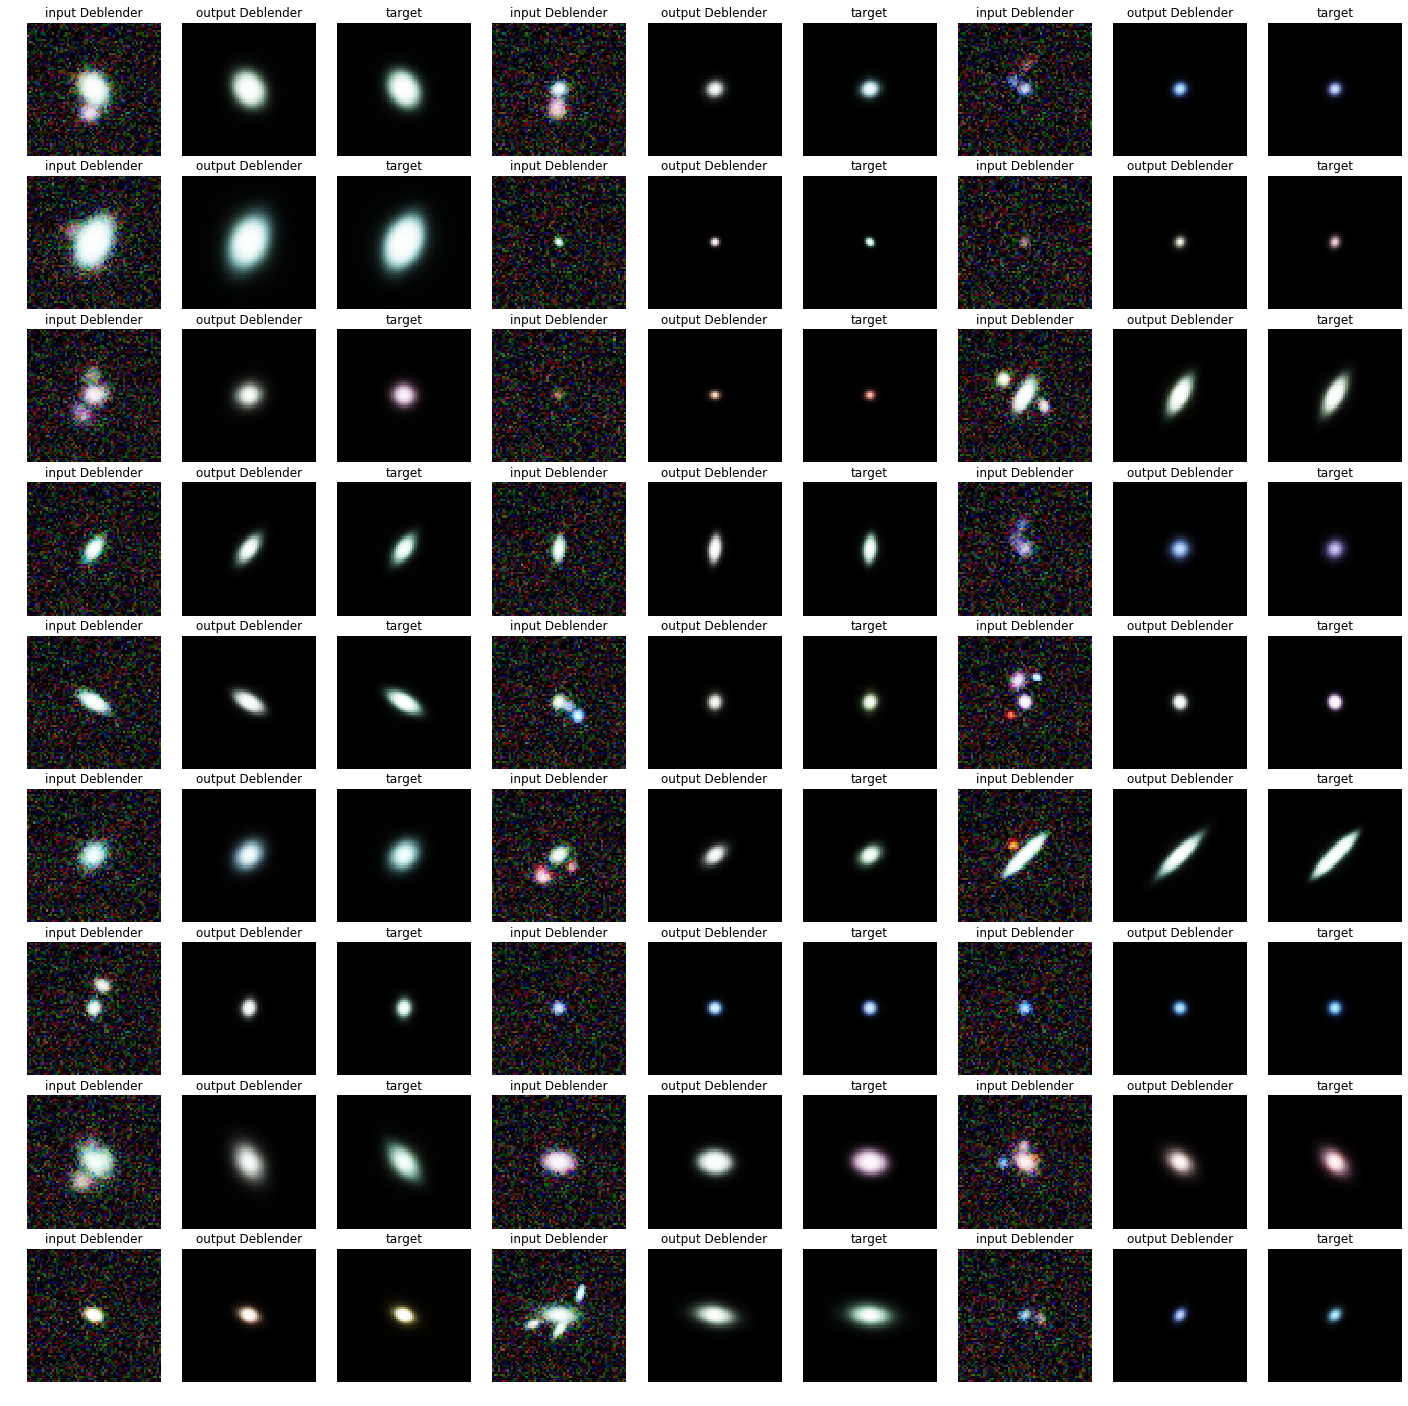

In [20]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
output_deblender_lsst = deblender.predict(input_lsst[0], batch_size = 100)


for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst(input_lsst[0][indices[i*N_plot+j]],stamp_size, axes[i,j])#input_vae
        plot_rgb_lsst(output_deblender_lsst[indices[i*N_plot+j]],stamp_size, axes[i,j+1])#output_vae
        plot_rgb_lsst(input_lsst[1][indices[i*N_plot+j]],stamp_size, axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

# Shape reproduction

In [56]:
test[i,1,6].reshape((64,64)).shape

(64, 64)

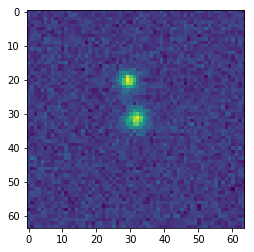

In [57]:
plt.imshow(test[i,1,6].reshape((64,64)))

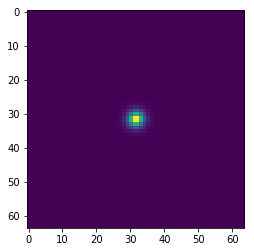

In [60]:
plt.imshow(test[i,0,6].reshape((64,64)))

In [72]:
output_vae = deblender.predict(test[:100,1,4:].reshape((100,64,64,6)), batch_size = batch_size)

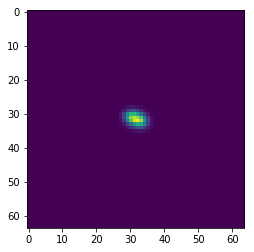

In [73]:
plt.imshow(output_vae[0].reshape((6,64,64))[2])

In [ ]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

band = 'i'

ellipticities = []

for j in range(100):#00
    a = batch_gen.__getitem__(2)
    output_vae = deblender.predict(a[0], batch_size = batch_size)#a[0] test[:,1,4:].reshape((10000,64,64,6))
    for i in range (len(a[0])):#a[0] test
        try: 
            gal_image = galsim.Image(a[1][i][:,:,2])# 6, a[1][i] test[i,0,6]
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_in = [res.corrected_e1, res.corrected_e2]

            gal_image = galsim.Image(output_vae[i][:,:,2])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_out = [res.corrected_e1, res.corrected_e2]

            ellipticities.append([e_in, e_out])

        except :
            print('error for galaxy '+str(j*100+i))
            pass
        continue

ellipticities_r_band = np.array(ellipticities)

error for galaxy 2001
error for galaxy 2901
error for galaxy 3427


In [ ]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    

In [12]:
batch_size = 100

In [13]:
a = batch_gen.__getitem__(2)
output_enc = encoder.predict(a[0], batch_size = batch_size)

In [14]:
latent_dim =32
epsilon_std = 1.0

In [15]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon


z = []
for i in range (100):
    a = batch_gen.__getitem__(2)
    output_enc = encoder.predict(a[0], batch_size = batch_size)
    z.append(sampling(output_enc))

In [16]:
z = np.concatenate(z, axis = 0)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


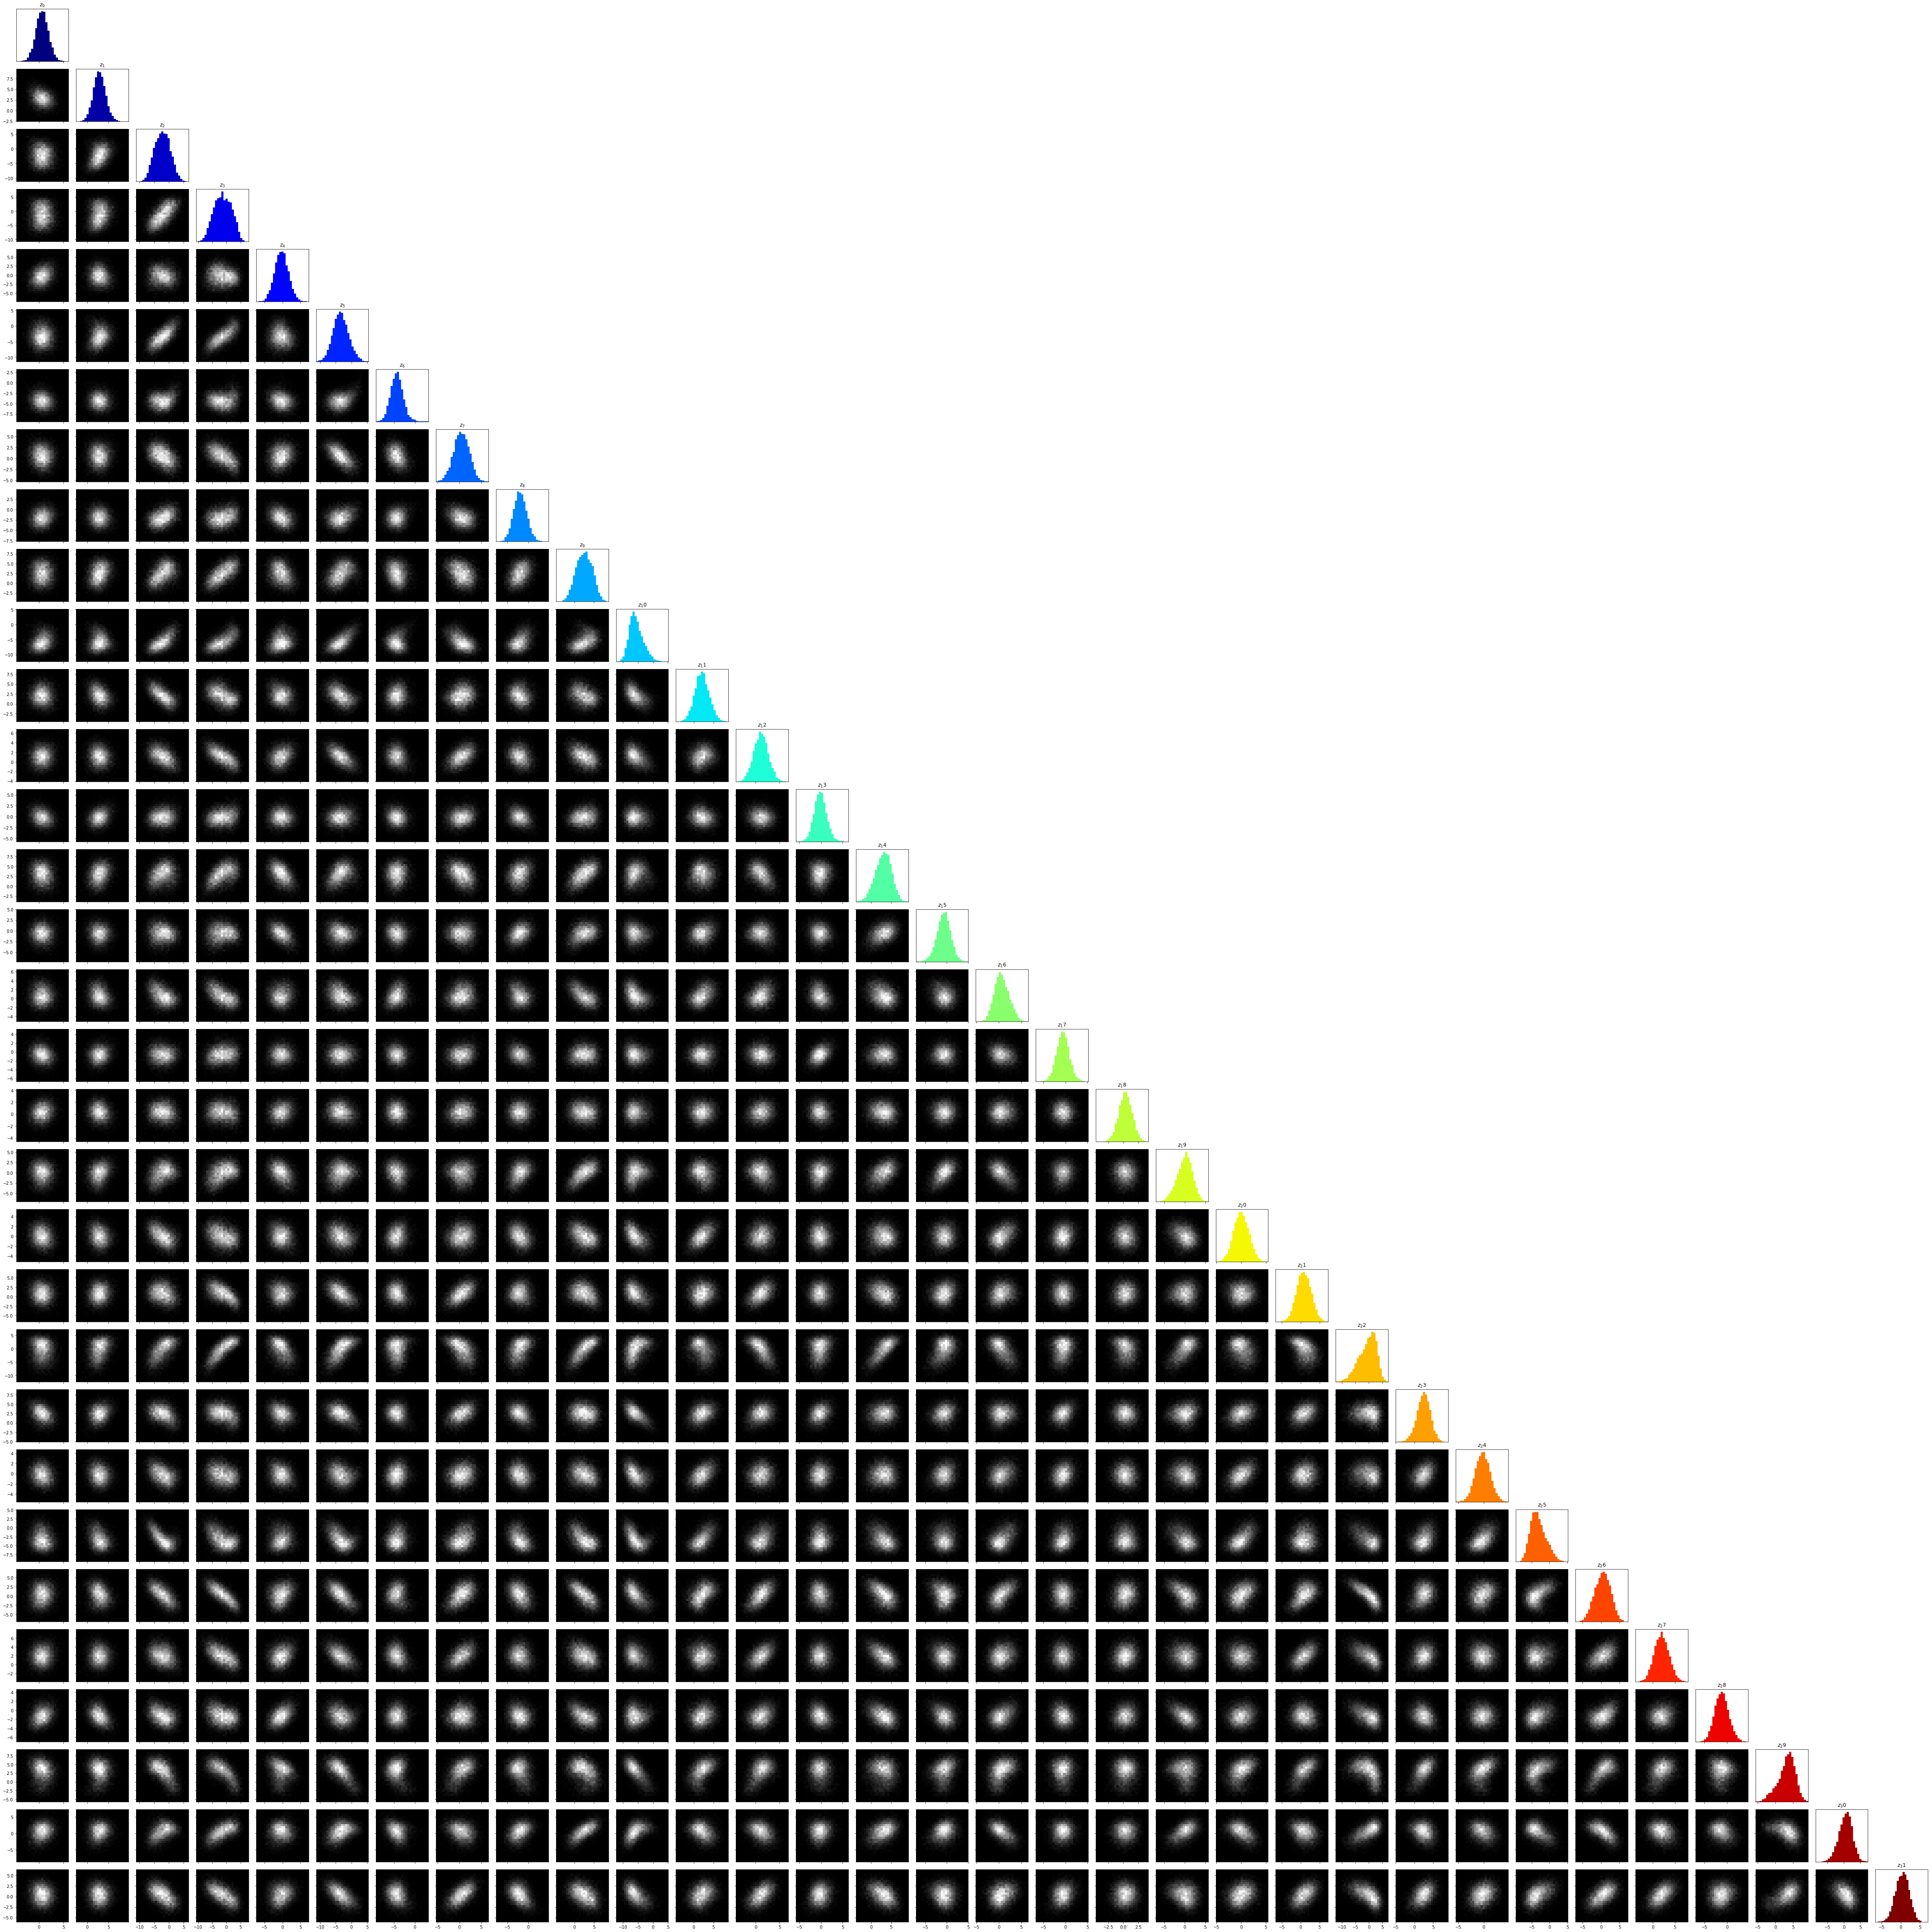

In [17]:
plot_corner_latent(z)

# Load the shifts to evaluate the distance between 2 galaxies

In [100]:
a = batch_gen.__getitem__(2)

In [103]:
a[2]

array([1.54662824, 1.1528244 , 1.5899578 , ..., 0.        , 1.53067556,
       1.81809236])

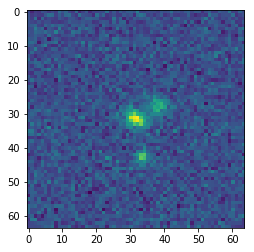

In [104]:
plt.imshow(a[0][0].reshape((6,64,64))[2])

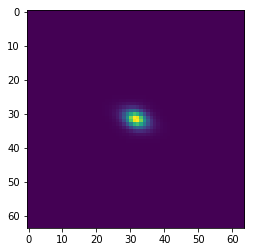

In [105]:
plt.imshow(a[1][0].reshape((6,64,64))[2])

### Same analysis as function of delta r : all the images with only one galaxy are suppressed

In [14]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

band = 'i'

ellipticities = []
delta_r = []

for j in range(100):
    a = batch_gen.__getitem__(2)
    output_vae = deblender.predict(a[0].reshape((100,64,64,6)), batch_size = batch_size)#a[0] test[:,1,4:].reshape((10000,64,64,6))
    for i in range (len(a[0])):#a[0] test
        try: 
            if (a[2][i]!=0):
                gal_image = galsim.Image(a[1][i].reshape((6,64,64))[2])# 6, a[1][i] test[i,0,6]
                gal_image.scale = pix_scale

                res = galsim.hsm.EstimateShear(gal_image, psf_image)
                e_in = [res.corrected_e1, res.corrected_e2]

                gal_image = galsim.Image(output_vae[i].reshape((6,64,64))[2])
                gal_image.scale = pix_scale

                res = galsim.hsm.EstimateShear(gal_image, psf_image)
                e_out = [res.corrected_e1, res.corrected_e2]

                ellipticities.append([e_in, e_out])
                delta_r.append(a[2][i])
        except :
            print('error for galaxy '+str(j*100+i))
            pass
        continue

ellipticities_r_band = np.array(ellipticities)
delta_r_list = np.array(delta_r)

error for galaxy 851
error for galaxy 1145
error for galaxy 1919
error for galaxy 2022
error for galaxy 2785


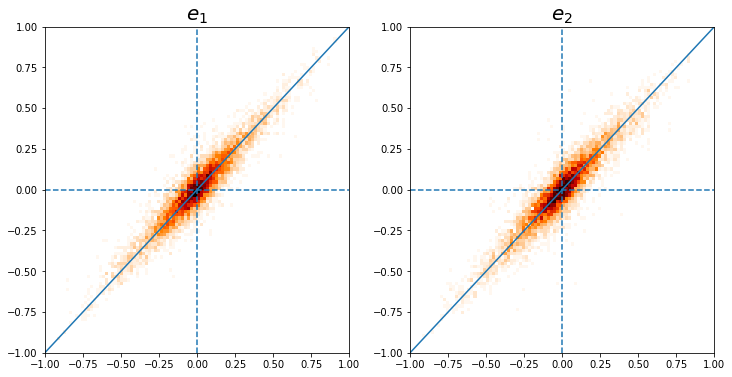

In [45]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'

In [46]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

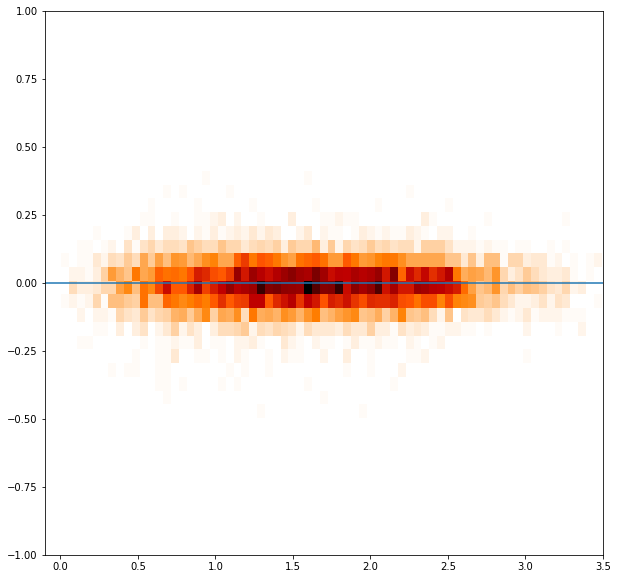

In [52]:
fig = plt.figure(figsize = (10,10))
_ = plt.hist2d(delta_r, delta_e1, bins=np.linspace(-1,4,100), cmap=mpl.cm.gist_heat_r)
plt.xlim(-0.1,3.5)
plt.ylim(-1,1)
plt.plot((-1, 4),(0,0))

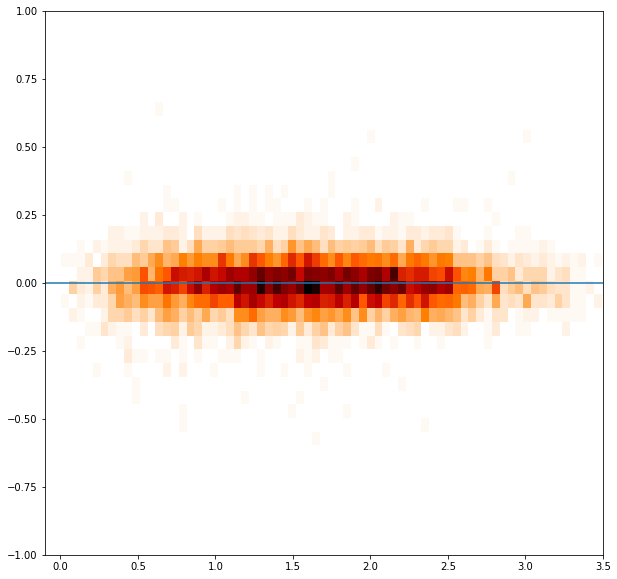

In [53]:
fig = plt.figure(figsize = (10,10))
_ = plt.hist2d(delta_r, delta_e2, bins=np.linspace(-1,4,100), cmap=mpl.cm.gist_heat_r)
plt.xlim(-0.1,3.5)
plt.ylim(-1,1)
plt.plot((-1, 4),(0,0))

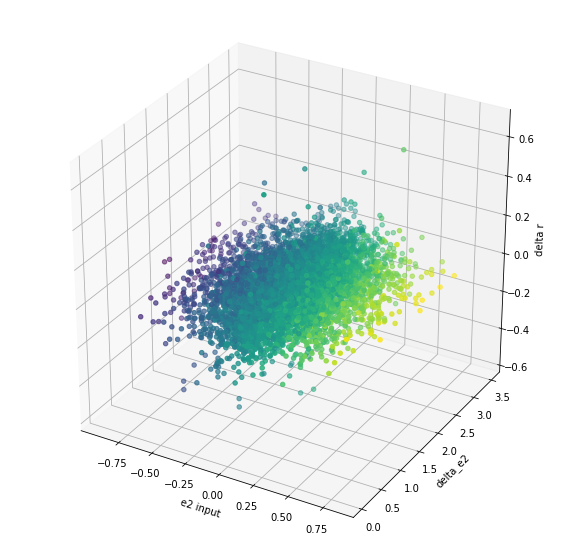

In [50]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

xs = ellipticities_r_band[:,0,1]
ys = delta_r
zs = delta_e2
ax.scatter(xs, ys, zs, c=xs, cmap='viridis')

ax.set_xlabel('e2 input')
ax.set_ylabel('delta_e2')
ax.set_zlabel('delta r')

plt.show()


### N sampling for the same galaxy on the 10 000 and take the mean

In [16]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

N_sampling = 100
N = 1

ellipticities_n = np.zeros((N_sampling, batch_size, 2,2 ))
ellipticities = []
delta_r = []
e = []


for j in range(N):
    a = batch_gen.__getitem__(2)
    for k in range (N_sampling):
        output_vae = deblender.predict(a[0].reshape((100,64,64,6)), batch_size = batch_size)

        for i in range (batch_size):
            if (a[2][i]!=0):
                try: 
                        gal_image = galsim.Image(a[1][i].reshape((6,64,64))[2])
                        gal_image.scale = pix_scale

                        res = galsim.hsm.EstimateShear(gal_image, psf_image)
                        e_in = [res.corrected_e1, res.corrected_e2]
                        e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]

                        gal_image = galsim.Image(output_vae[i].reshape((6,64,64))[2])
                        gal_image.scale = pix_scale

                        res = galsim.hsm.EstimateShear(gal_image, psf_image)
                        e_out = [res.corrected_e1, res.corrected_e2]
                        e_beta_out = [res.observed_shape.e, res.observed_shape.beta.rad]

                        ellipticities_n[k,i] = [e_in, e_out]
                        e.append([e_beta_in, e_beta_out])
                except :
                    print('error for galaxy '+str(j*100+i)+' sample '+str(k))
                    pass
                continue
                delta_r.append(a[2][i])
    print(np.array(ellipticities_n).shape)
    
    ellipticities.append(np.mean(np.array(ellipticities_n), axis = 0))
    print(np.array(ellipticities).shape)
        
        
ellipticities_r_band = np.array(ellipticities).reshape((100,2,2))
delta_r_list = np.array(delta_r)
e_beta = np.array(e)

(100, 100, 2, 2)
(1, 100, 2, 2)


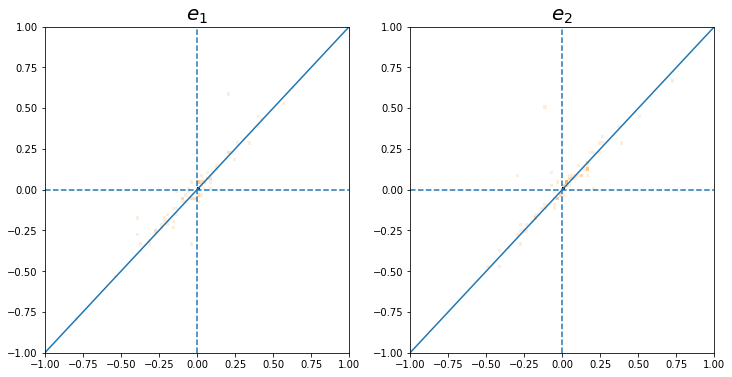

In [18]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'

In [24]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

ValueError: The dimension of bins must be equal to the dimension of the  sample x.

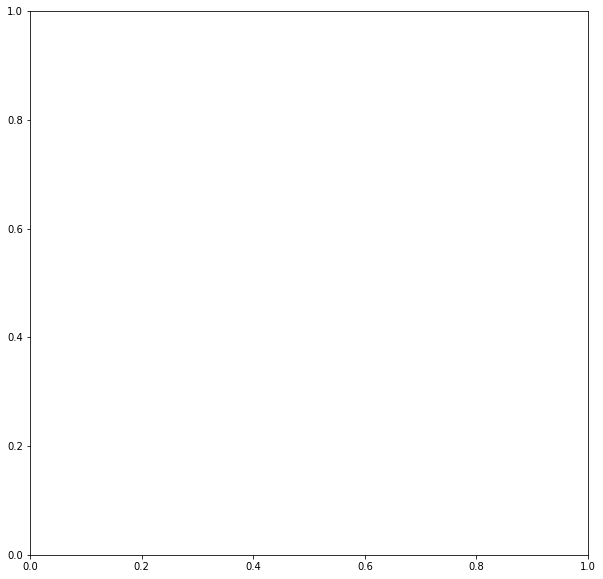

In [26]:
fig = plt.figure(figsize = (10,10))
_ = plt.hist2d(delta_r, delta_e1, bins=np.linspace(-1,4,10), cmap=mpl.cm.gist_heat_r)
plt.xlim(-0.1,3.5)
plt.ylim(-1,1)
plt.plot((-1, 4),(0,0))

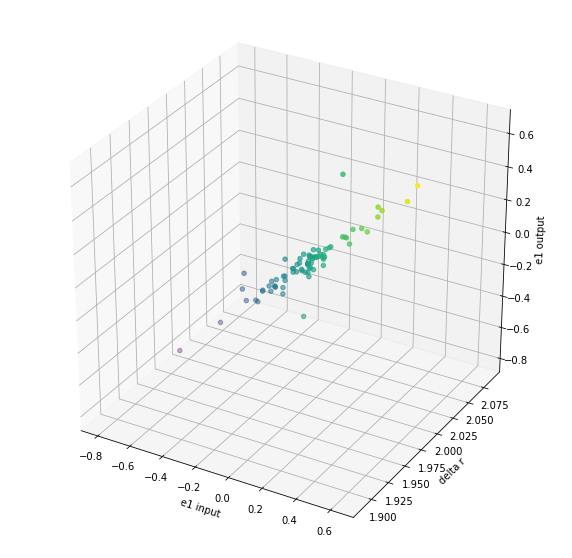

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

xs = ellipticities_r_band[:,0,0]
ys = delta_r
zs = ellipticities_r_band[:,1,0]
ax.scatter(xs, ys, zs, c=xs, cmap='viridis')

ax.set_xlabel('e1 input')
ax.set_ylabel('delta r')
ax.set_zlabel('e1 output')

plt.show()

In [ ]:
# define the number of samplings
N = 3
nb_of_samplings = 10

batch_size = 100

In [ ]:
# Define the PSF used for measurement
PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
final_epsf_image = PSF.drawImage(scale=0.2)

In [ ]:
res_out_r_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_r_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')


gal = []
err_count = 0

for i in range (N):
    list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)
    gal.append(list_galsim_simple[0][0])
    
    plt.imshow(list_galsim_simple[0][0].reshape((10,64,64))[6])#
    for k in range (len(list_galsim_simple[0])):
        list_galsim_simple[0][k] = gal[i]
    try: 
        print(i)
        for j in range (nb_of_samplings):
            print(j)
            output_vae_list_r = vae_lsst_r_band_conv.predict(list_galsim_simple[0].reshape((batch_size,10,64,64))[:,6], batch_size = batch_size)
            output_vae_list_r = output_vae_list_r.reshape((batch_size,64,64))

            output_vae_list_lsst = vae_lsst_conv.predict(list_galsim_simple[0].reshape((batch_size,10,64,64))[:,4:].reshape((batch_size,64,64,6)), batch_size = batch_size)
            output_vae_list_lsst = output_vae_list_lsst.reshape((batch_size,6,64,64))

            output_vae_list_lsst_euclid = vae_lsst_euclid_conv.predict(list_galsim_simple[0], batch_size = batch_size)
            output_vae_list_lsst_euclid = output_vae_list_lsst_euclid.reshape((batch_size,10,64,64))

            for t in range (batch_size):
                img_out_simple = galsim.Image(output_vae_list_r[t])
                res_out_r_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_r_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2

                img_out_simple = galsim.Image(output_vae_list_lsst[t,2])
                res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2

                img_out_simple = galsim.Image(output_vae_list_lsst_euclid[t,6])
                res_out_lsst_euclid_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_lsst_euclid_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
#print(res_out[i,j*batch_size+t])

            
            
    except :
        err_count +=1
        print('erreur')
        pass
    continue
            
print(err_count)

In [ ]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(gal[k].reshape((10,64,64))[6])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    print(res_in_e1[k], res_in_e2[k])

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(2,3, figsize=(25,14))

ax = axes[0,0]
_ = ax.hist(res_out_r_e1[0],  bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[0], bins = 50,label ='LSST filters' ,  alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[0], bins = 50,label = 'LSST+Euclid \n filters' ,  alpha = 0.5)
variance = np.var(res_out_r_e1[0])
sigma = np.sqrt(variance)
x = np.linspace(min(res_out_r_e1[0]), max(res_out_r_e1[0]), 100)
#ax.plot(x, mlab.normpdf(x, mean, sigma))


ax.axvline(res_in_e1[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,1]
_ = ax.hist(res_out_r_e1[1] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[1] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[1] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e1[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,2]
_ = ax.hist(res_out_r_e1[2] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[2] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[2] , bins = 50,label = 'LSST+Euclid \n filters' ,  alpha = 0.5)

ax.axvline(res_in_e1[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e1')
ax.legend()

ax = axes[1,0]
_ = ax.hist(res_out_r_e2[0] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[0] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[0] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,1]
_ = ax.hist(res_out_r_e2[1] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[1] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[1] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,2]
_ = ax.hist(res_out_r_e2[2] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[2] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[2] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e2')
ax.legend()

plt.tight_layout()

# Compare deblender LSST vs LSST+Euclid

In [41]:
def compare_deblender(deb1, deb2,nb_1, nb_2, input_deb_1, input_deb_2, expected):
    ######
    # deb1, deb2 : the 2 deblenders which are being compared
    # nb_1, nb_2 : number of bands in the images processed respectively by deb1 and deb2
    # input_deb_1, input_deb_2 : the noisy blended images to process respectively for deb1 and deb2
    # expected: the noiseless centered galaxy images which are the targerts for the deblender 1
    ######
    # List of noisy blended images
    list_blended_1 = input_deb_1.reshape(len(input_deb_1),64,64,nb_1)
    list_blended_2 = input_deb_2.reshape(len(input_deb_2),64,64,nb_2)
    print(list_blended_1.shape)
    # List of noiseless centered galaxy
    list_simple = expected
    
    # Use deblenders on list of blended images
    list_output_1 = deb1.predict(list_blended_1, batch_size= 100)
    list_output_2 = deb2.predict(list_blended_2, batch_size= 100)
    
    # Reshape the lists so that it can be used for measurement
    list_output_1 = list_output_1.reshape(len(input_deb_1),nb_1,64,64)
    list_output_2 = list_output_2.reshape(len(input_deb_2),nb_2,64,64)
    print(list_output_1.shape)
    list_simple = list_simple.reshape(len(expected),nb_1,64,64)

    # Create empty lists for the futur measurements
    g_in = np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    g1_in= np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    g2_in= np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    
    g_out_1 = np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')
    g1_out_1= np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')
    g2_out_1= np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')

    g_out_2 = np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')
    g1_out_2= np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')
    g2_out_2= np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')

    err_count = 0
    for i in range (100):#len(input_deb_1)):
#        try :
        #print('image : '+str(i))
        # Add a PSF to be able to do an estimation of the shear
        PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
        final_epsf_image = PSF.drawImage(scale=0.2)

        # Define the images
        img_in = galsim.Image(list_simple[i,nb_1-4,16:48,16:48])
        #print(list_blended_1.shape)
        img_out_1 = galsim.Image(list_output_1[i,nb_1-4,16:48,16:48])
        img_out_2 = galsim.Image(list_output_2[i,nb_2-4,16:48,16:48])
        #print(list_output_1[i,nb_1-4,16:48,16:48].shape, str(nb_1-4))
        #print(list_output_2[i,nb_2-4,16:48,16:48].shape, str(nb_2-4))
        #plt.imshow(list_output_1[i,nb_1-4])
        # Measurements 
        ## for the input image
        g_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g
        #print(g_in[i])
        g1_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g1
        #print(g1_in[i])
        g2_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g2
        #print(g2_in[i])
        
        ## for the output image for the deblender deb1
        g_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g
        #print(g_out_1[i])
        g1_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g1
        #print(g1_out_1[i])
        g2_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g2
        #print(g2_out_1[i])
        ## for the output image for the deblender deb2
        g_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g
        #print(g_out_2[i])
        g1_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g1
        #print(g1_out_2[i])
        g2_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g2
        #print(g2_out_2[i])
#        except :
#            err_count +=1
#            print('erreur')
#            pass
#        continue
#    print(err_count)
    
    return g_in, g1_in, g2_in, g_out_1, g1_out_1, g2_out_1, g_out_2, g1_out_2, g2_out_2

In [42]:
g_in, g1_in, g2_in, g_out_1, g1_out_1, g2_out_1, g_out_2, g1_out_2, g2_out_2 = compare_deblender(deblender_lsst, deblender_lsst_euclid,6,10,input_deblender_lsst, input_deblender_lsst_euclid, input_deblender_no_noise_lsst)

(10000, 64, 64, 6)
(10000, 6, 64, 64)
image : 0
0.2082479
0.19913106
-0.060942654
0.036790792
0.034009717
-0.014032165
0.16499282
0.15605693
-0.0535618
image : 1
0.16798127
-0.026451362
0.1658856
0.15658477
-0.03602771
0.15238371
0.17420697
-0.019408643
0.17312242
image : 2
0.015851352
-0.0019065625
-0.015736276
0.08868295
-0.021780383
-0.085966736
0.02348353
-0.021882499
-0.008522464
image : 3
0.021669954
0.014525538
0.016080908
0.020390408
0.020253738
-0.002356865
0.03144208
0.021906106
0.022554975
image : 4
0.20160483
-0.0011992565
0.20160127
0.20832688
0.00688239
0.20821317
0.18581249
0.011259531
0.18547103
image : 5
0.23158796
-0.104689494
0.20657468
0.23533344
-0.12658247
0.19839028
0.2287074
-0.10791111
0.20164888
image : 6
0.11998794
-0.117808565
-0.022765057
0.07408505
-0.010791827
-0.07329482
0.10861742
-0.10680394
-0.01976517
image : 7
0.049526952
-0.0055145873
-0.049218982
0.04815506
0.0016616306
-0.04812638
0.06094573
-0.003158866
-0.06086381
image : 8
0.04619206
-0.017668

-0.12442082
0.10392915
0.04133713
-0.095354654
image : 74
0.11875908
0.112435594
0.03823554
0.12378496
0.122179255
0.01987324
0.08360412
0.076007724
0.034820616
image : 75
0.20552595
-0.003458937
-0.20549685
0.20924947
-0.036455277
-0.20604938
0.18458277
0.0022645297
-0.18456888
image : 76
0.13287856
-0.12798539
0.03572745
0.13762611
-0.13466565
0.02839205
0.14154579
-0.13268964
0.049281526
image : 77
0.12189686
0.05458897
0.10899032
0.04391239
0.040948823
0.015858488
0.12846608
0.053195484
0.11693492
image : 78
0.07118125
0.06414389
0.03085987
0.05739784
0.054537885
0.017892204
0.057015285
0.044195596
0.036020715
image : 79
0.3680707
0.28004238
0.23885626
0.36813596
0.26644644
0.25402832
0.36800182
0.25942957
0.2610012
image : 80
0.1587331
-0.07762931
-0.13845536
0.19166158
-0.09155821
-0.16837832
0.16123722
-0.09631994
-0.1293055
image : 81
0.05116644
-0.035789974
-0.036566135
0.052614756
0.0011119178
-0.052603006
0.037910182
0.0035725504
-0.03774147
image : 82
0.12260909
-0.06430983

In [43]:
# Calculate the differences from output measurement compared to input
## LSST
delta_g_lsst = g_in - g_out_1
delta_g1_lsst = g1_in- g1_out_1
delta_g2_lsst = g2_in-g2_out_1

## LSST + Euclid
delta_g_lsst_euclid = g_in - g_out_2
delta_g1_lsst_euclid = g1_in- g1_out_2
delta_g2_lsst_euclid = g2_in-g2_out_2


The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


ValueError: weights should have the same shape as a.

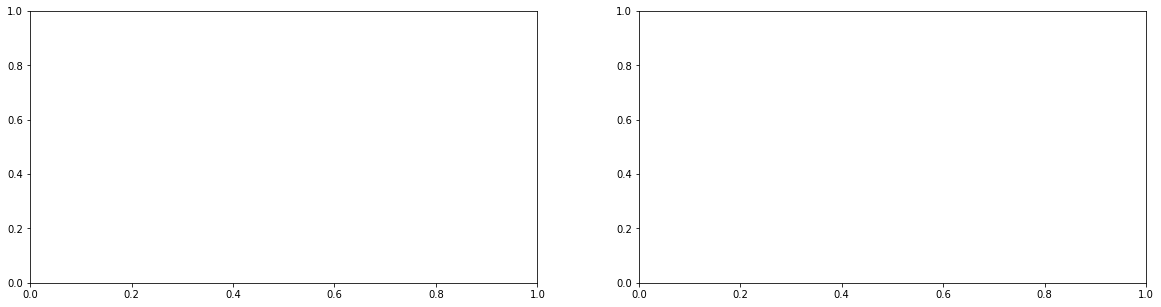

In [63]:
# Plot of the LSST and LSST+Euclid results comparison

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

bins = np.linspace(0, 50,100)
mid = (bins[1:]+bins[:-1])*0.5

mean_delta_g, var_delta_g = mean_var(delta_r,delta_g_lsst_euclid,bins)
mean_delta_g1, var_delta_g1 = mean_var(delta_r,delta_g1_lsst_euclid,bins)
mean_delta_g2, var_delta_g2 = mean_var(delta_r,delta_g2_lsst_euclid,bins)

mean_delta_g_lsst, var_delta_g_lsst = mean_var(delta_r,delta_g_lsst,bins)
mean_delta_g1_lsst, var_delta_g1_lsst = mean_var(delta_r,delta_g1_lsst,bins)
mean_delta_g2_lsst, var_delta_g2_lsst = mean_var(delta_r,delta_g2_lsst,bins)



ax = axes[0]
ax.plot(mid, mean_delta_g1, label = 'LSST-EUCLID')
ax.fill_between(mid, mean_delta_g1 - 10*var_delta_g1**0.5, mean_delta_g1 + 10*var_delta_g1**0.5, alpha=0.5)
ax.plot(mid, mean_delta_g1_lsst, label = 'LSST')
ax.fill_between(mid, mean_delta_g1_lsst - 10*var_delta_g1_lsst**0.5, mean_delta_g1_lsst + 10*var_delta_g1_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g1', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.plot(mid,mid*0)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
ax.set_ylim(-0.5,0.5)

ax = axes[1]
ax.plot(mid, mean_delta_g2, label = 'LSST-EUCLID')
ax.fill_between(mid, mean_delta_g2 - 10*var_delta_g2**0.5, mean_delta_g2 + 10*var_delta_g2**0.5, alpha=0.5)
ax.plot(mid, mean_delta_g2_lsst, label = 'LSST')
ax.fill_between(mid, mean_delta_g2_lsst - 10*var_delta_g2_lsst**0.5, mean_delta_g2_lsst + 10*var_delta_g2_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g2', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.plot(mid,mid*0)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
#ax.set_ylim(-0.5,0.5)

### Only the LSST results

In [ ]:
# Plot of the LSST results only

ig, axes = plt.subplots(1, 2, figsize=(20, 5))

bins = np.linspace(0, 50,100)
mid = (bins[1:]+bins[:-1])*0.5

mean_delta_g_lsst, var_delta_g_lsst = mean_var(delta_r_2,delta_g_lsst,bins)
mean_delta_g1_lsst, var_delta_g1_lsst = mean_var(delta_r_2,delta_g1_lsst,bins)
mean_delta_g2_lsst, var_delta_g2_lsst = mean_var(delta_r_2,delta_g2_lsst,bins)


#ax = axes[0]
#ax.plot(mid,mean_delta_g_lsst, label = 'LSST')
#ax.fill_between(mid, mean_delta_g_lsst - 10*var_delta_g_lsst**0.5, mean_delta_g_lsst + 10*var_delta_g_lsst**0.5, alpha=0.5)
#ax.set_ylabel('delta g', fontsize = 10)
#ax.set_xlabel('delta r', fontsize = 10)
#ax.legend(fontsize = 10)
#ax.set_xlim(0,40)
#ax.set_ylim(-0.5,0.5)

ax = axes[0]
ax.plot(mid, mean_delta_g1_lsst, label = 'LSST')
ax.plot(mid,mid*0)
ax.fill_between(mid, mean_delta_g1_lsst - 10*var_delta_g1_lsst**0.5, mean_delta_g1_lsst + 10*var_delta_g1_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g1', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
ax.set_ylim(-0.5,0.5)

ax = axes[1]
ax.plot(mid, mean_delta_g2_lsst, label = 'LSST')
ax.plot(mid,mid*0)
ax.fill_between(mid, mean_delta_g2_lsst - 10*var_delta_g2_lsst**0.5, mean_delta_g2_lsst + 10*var_delta_g2_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g2', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
ax.set_ylim(-0.5,0.5)